In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from sklearn import preprocessing as prep
import skimage.io
import pickle
from glob import glob
import pathlib
import seaborn as sns
import zipfile
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import warnings
warnings.filterwarnings("ignore")


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1788199115146012509
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 13812936256
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16906434475743785864
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [5]:
tf.device('cuda')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
labels = np.array(['activate lamp none', 'activate lights bedroom', 'activate lights kitchen',
 'activate lights none', 'activate lights washroom', 'activate music none',
 'bring juice none', 'bring newspaper none', 'bring shoes none',
 'bring socks none', 'change language Chinese none',
 'change language English none', 'change language German none',
 'change language Korean none', 'change language none none',
 'deactivate lamp none', 'deactivate lights bedroom',
 'deactivate lights kitchen', 'deactivate lights none',
 'deactivate lights washroom', 'deactivate music none',
 'decrease heat bedroom', 'decrease heat kitchen', 'decrease heat none',
 'decrease heat washroom', 'decrease volume none', 'increase heat bedroom',
 'increase heat kitchen', 'increase heat none', 'increase heat washroom',
 'increase volume none'])
#print(labels)

#####Execute the following cell if a zip file is used to store preprocessed dataset

In [30]:
root_path = '/content'
with zipfile.ZipFile('/content/4_sec-20201218T213704Z-001.zip', 'r') as zip_ref:
    zip_ref.extractall(root_path)
os.chdir(root_path+'/4_sec')

#####Execute the following cell if preprocess data is copied directed from Google Drive

In [32]:
os.chdir(root_path+'/4_sec')
#%cp -av '/content/drive/MyDrive/fluent_speech_commands_dataset/4_sec/' '/content'

In [33]:
input_shape = (624, 257, 3)
print('Input shape:', input_shape)
num_labels = labels.shape[0]
print(num_labels)
nrow = input_shape[0]
ncol = input_shape[1]
print(nrow)
print(ncol)

Input shape: (624, 257, 3)
31
624
257


In [ ]:
#train_ds = tf.keras.preprocessing.image_dataset_from_directory('./train',labels="inferred")

In [34]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 50
train_data_dir = './train'
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.0,
                                   horizontal_flip=False)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        classes=labels.tolist(),
                        class_mode= 'sparse')

Found 22751 images belonging to 31 classes.


In [35]:
test_data_dir = './test'
test_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.0,
                                   horizontal_flip=False)
test_generator = test_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        classes=labels.tolist(),
                        class_mode='sparse')

Found 3743 images belonging to 31 classes.


In [36]:
val_data_dir = './val'
val_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.0,
                                   horizontal_flip=False)
val_generator = val_datagen.flow_from_directory(
                        val_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        classes=labels.tolist(),
                        class_mode='sparse')

Found 3094 images belonging to 31 classes.


In [ ]:
'''
# Load dataset
train_ds = keras.preprocessing.image_dataset_from_directory('Data/train',labels="inferred")
val_ds = keras.preprocessing.image_dataset_from_directory('Data/test',labels="inferred")

# Standardize data (optional)
from tensorflow.keras import layers
normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Cache to RAM (optional)
from tensorflow import data
AUTOTUNE = data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Train
model.fit(train_ds, validation_data=val_ds, epochs=3)
'''

'\n# Load dataset\ntrain_ds = keras.preprocessing.image_dataset_from_directory(\'Data/train\',labels="inferred")\nval_ds = keras.preprocessing.image_dataset_from_directory(\'Data/test\',labels="inferred")\n\n# Standardize data (optional)\nfrom tensorflow.keras import layers\nnormalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)\ntrain_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))\nval_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))\n\n# Cache to RAM (optional)\nfrom tensorflow import data\nAUTOTUNE = data.experimental.AUTOTUNE\ntrain_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)\nval_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)\n\n# Train\nmodel.fit(train_ds, validation_data=val_ds, epochs=3)\n'

In [37]:
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense,Conv2D, MaxPooling2D, Input, BatchNormalization

In [38]:
import tensorflow.keras.backend as K
K.clear_session()

In [39]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import decode_predictions, preprocess_input  
base_model = applications.VGG19(include_top=False, weights='imagenet', input_shape = input_shape)

80142336/80134624 [==============================] - 0s 0us/step


In [40]:
model = Sequential()
use_base_model = True #If false, model may have to be adjusted to account for image size.

In [41]:
#Loop over base_model.layers and add each layer to model
if use_base_model:
  for layer in base_model.layers:
    model.add(layer)

  for layer in model.layers:
    layer.trainable = False
  model.add(BatchNormalization())
else:
  model.add(Input(shape=input_shape))
  model.add(Resizing(128, 128))

In [42]:
model.add(Conv2D(256, 3, activation='relu'))
model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(num_labels))


In [49]:
#model.get_layer('block5_conv2').trainable=True
#model.get_layer('block5_conv3').trainable=True
model.get_layer('block5_conv4').trainable=True

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 624, 257, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 624, 257, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 312, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 312, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 312, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 156, 64, 128)      0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 156, 64, 256)      2

In [44]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [45]:
steps_per_epoch = len(train_generator.filepaths)//batch_size
validation_steps = len(val_generator.filepaths)//batch_size
print(f'Steps per epoch = {steps_per_epoch}')
print(f'Validadtion Steps = {validation_steps}')

Steps per epoch = 455
Validadtion Steps = 61


In [47]:
EPOCHS = 10
history = model.fit(
    train_generator, 
    validation_data=val_generator,  
    validation_steps=validation_steps,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    #callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/10
455/455 [==============================] - 443s 974ms/step - loss: 1.6225 - accuracy: 0.4293 - val_loss: 2.1310 - val_accuracy: 0.3518
Epoch 2/10
455/455 [==============================] - 442s 972ms/step - loss: 1.5180 - accuracy: 0.4676 - val_loss: 2.1075 - val_accuracy: 0.3705
Epoch 3/10
455/455 [==============================] - 442s 972ms/step - loss: 1.4008 - accuracy: 0.5003 - val_loss: 2.0763 - val_accuracy: 0.3793
Epoch 4/10
455/455 [==============================] - 443s 973ms/step - loss: 1.3369 - accuracy: 0.5238 - val_loss: 1.9038 - val_accuracy: 0.4331
Epoch 5/10
455/455 [==============================] - 443s 973ms/step - loss: 1.3262 - accuracy: 0.5329 - val_loss: 2.9095 - val_accuracy: 0.3046
Epoch 6/10
455/455 [==============================] - 443s 972ms/step - loss: 1.3637 - accuracy: 0.5229 - val_loss: 2.3239 - val_accuracy: 0.3830
Epoch 7/10
455/455 [==============================] - 442s 972ms/step - loss: 1.1893 - accuracy: 0.5731 - val_loss: 2.0373 -

In [48]:
model.save('/content/drive/MyDrive/fluent_speech_commands_dataset/model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/fluent_speech_commands_dataset/model/assets


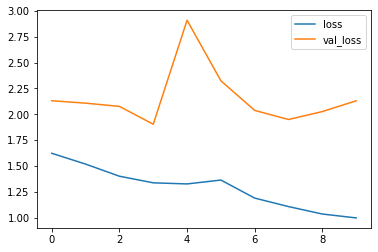

In [51]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()